### imports and configurations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- CONFIGURATION ---
# Path to dataset in Kaggle (default path after adding data)
DATA_PATH = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'

# Hyperparameters & Settings
SEQ_LENGTH = 60          # Input sequence length 
BATCH_SIZE = 64          # Specified in instructions 
SAMPLE_RATE = 0.2        # Use only 20% of data for faster execution
DEBUG_EPOCHS = 2         # Low epoch count for testing correctness
FULL_EPOCHS = 20         # Target epochs for final training
TARGET_COL = 'Global_active_power'

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


### loading and preprocessing of data

In [2]:
def load_and_preprocess_data(path, sample_rate=1.0):
    print("Loading dataset...")
    # Read CSV without parsing dates to speed up loading
    df = pd.read_csv(path, sep=';', low_memory=False, na_values=['nan', '?'])
    
    # Downsample
    if sample_rate < 1.0:
        cutoff = int(len(df) * sample_rate)
        df = df.iloc[:cutoff]
        print(f"Data downsampled to first {sample_rate*100}%: {len(df)} rows")
    
    # Handle missing values (Forward Fill)
    df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
    df[TARGET_COL] = df[TARGET_COL].ffill()
    
    data = df[[TARGET_COL]].values.astype(float)
    return data

def create_sliding_window(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# --- EXECUTION ---
# 1. Load data
raw_data = load_and_preprocess_data(DATA_PATH, SAMPLE_RATE)

# 2. Split indices (70% Train, 15% Val, 15% Test)
n = len(raw_data)
train_split = int(n * 0.70)
val_split = int(n * 0.85)

train_data = raw_data[:train_split]
val_data = raw_data[train_split:val_split]
test_data = raw_data[val_split:]

# 3. Standardization (Fit on Train ONLY)
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)
val_data_norm = scaler.transform(val_data)
test_data_norm = scaler.transform(test_data)

# 4. Create Sliding Windows
print("Creating sliding windows...")
X_train, y_train = create_sliding_window(train_data_norm, SEQ_LENGTH)
X_val, y_val = create_sliding_window(val_data_norm, SEQ_LENGTH)
X_test, y_test = create_sliding_window(test_data_norm, SEQ_LENGTH)

# 5. Convert to PyTorch Tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data processing complete.")

Loading dataset...
Data downsampled to first 20.0%: 415051 rows
Creating sliding windows...
Data processing complete.


### test data shapes

In [3]:
# --- TEST BLOCK ---
def test_data_shapes():
    print("--- Data Integrity Check ---")
    
    # Check 1: Shapes
    print(f"Train Shape: {X_train.shape} (Expected: [N, 60, 1])")
    print(f"Val Shape:   {X_val.shape}")
    print(f"Test Shape:  {X_test.shape}")
    
    # Check 2: Batch loading
    sample_x, sample_y = next(iter(train_loader))
    print(f"\nBatch X Shape: {sample_x.shape} (Expected: [64, 60, 1])")
    print(f"Batch y Shape: {sample_y.shape} (Expected: [64, 1])")
    
    # Check 3: Standardization
    # Mean of train should be close to 0, Std close to 1
    mean_val = np.mean(X_train)
    std_val = np.std(X_train)
    print(f"\nScaled Train Mean: {mean_val:.4f} (Should be ~0)")
    print(f"Scaled Train Std:  {std_val:.4f} (Should be ~1)")
    
    if abs(mean_val) > 0.1 or abs(std_val - 1) > 0.1:
        print("WARNING: Standardization might be incorrect.")
    else:
        print("SUCCESS: Standardization looks correct.")

test_data_shapes()

--- Data Integrity Check ---
Train Shape: (290475, 60, 1) (Expected: [N, 60, 1])
Val Shape:   (62198, 60, 1)
Test Shape:  (62198, 60, 1)

Batch X Shape: torch.Size([64, 60, 1]) (Expected: [64, 60, 1])
Batch y Shape: torch.Size([64, 1]) (Expected: [64, 1])

Scaled Train Mean: -0.0002 (Should be ~0)
Scaled Train Std:  0.9997 (Should be ~1)
SUCCESS: Standardization looks correct.


# Part A

### Model Definitions

In [4]:
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional=True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True)
        
        # Input to FC is doubled because of concatenation (Forward + Backward)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Hidden state shape: (num_layers * 2, batch, hidden_size)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Training Engine

In [5]:
import time
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    history = {'train_loss': [], 'val_loss': [], 'epoch_times': []}
    model.to(device)
    
    print(f"Training {model.__class__.__name__} for {num_epochs} epochs...")
    
    # Outer loop for epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # --- Training Phase ---
        model.train()
        train_losses = []
        
        # Progress bar per batch (Iteration level)
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            # Update progress bar description with current batch loss
            pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
            
        # --- Validation Phase ---
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())
        
        end_time = time.time()
        epoch_duration = end_time - start_time
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['epoch_times'].append(epoch_duration)
        
        # Update final description for the epoch
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
            
    return history, model

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    mse_losses = []
    mae_losses = []
    l1_criterion = nn.L1Loss()
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mse_losses.append(criterion(outputs, y_batch).item())
            mae_losses.append(l1_criterion(outputs, y_batch).item())
            
    return np.mean(mse_losses), np.mean(mae_losses)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### MODEL INTEGRITY CHECKS

In [6]:
# --- MODEL INTEGRITY CHECKS ---
def test_models():
    print("--- Testing Model Architectures ---")
    models = [
        SimpleRNNModel(),
        LSTMModel(),
        GRUModel(),
        BiLSTMModel()
    ]
    
    # Create a dummy batch
    dummy_x = torch.randn(64, SEQ_LENGTH, 1).to(device)
    
    for model in models:
        model.to(device)
        try:
            output = model(dummy_x)
            expected_shape = torch.Size([64, 1])
            
            print(f"Testing {model.__class__.__name__}:")
            print(f"  Output Shape: {output.shape}")
            print(f"  Parameters: {count_parameters(model)}")
            
            assert output.shape == expected_shape, f"Shape mismatch for {model.__class__.__name__}"
            print("  Status: OK")
            
        except Exception as e:
            print(f"  Status: FAILED with error: {e}")
            raise e

# Run the test
test_models()

--- Testing Model Architectures ---
Testing SimpleRNNModel:
  Output Shape: torch.Size([64, 1])
  Parameters: 12673
  Status: OK
Testing LSTMModel:
  Output Shape: torch.Size([64, 1])
  Parameters: 50497
  Status: OK
Testing GRUModel:
  Output Shape: torch.Size([64, 1])
  Parameters: 37889
  Status: OK
Testing BiLSTMModel:
  Output Shape: torch.Size([64, 1])
  Parameters: 133761
  Status: OK


### The Engine

In [7]:
def run_comparison_experiment(epochs, loader_pack, device, lr=0.001):
    """
    Runs training and evaluation for all 4 models.
    Returns the results dataframe and the dictionary of trained models.
    """
    train_loader, val_loader, test_loader = loader_pack
    results = {}
    trained_models = {} 
    
    model_classes = [SimpleRNNModel, LSTMModel, GRUModel, BiLSTMModel]
    
    print(f"--- Starting Comparison Experiment (Epochs: {epochs}) ---")

    for model_class in model_classes:
        model_name = model_class.__name__
        
        # 1. Setup
        model = model_class(input_size=1, hidden_size=64, num_layers=2, output_size=1)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # 2. Train
        # train_model returns (history, trained_model_instance)
        history, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device)
        trained_models[model_name] = trained_model
        
        # 3. Evaluate
        test_mse, test_mae = evaluate_model(trained_model, test_loader, criterion, device)
        
        # 4. Metrics
        total_params = count_parameters(trained_model)
        avg_time = np.mean(history['epoch_times'])
        
        # Convergence logic
        best_val = min(history['val_loss'])
        threshold = best_val * 1.10
        conv_epoch = next((i+1 for i, v in enumerate(history['val_loss']) if v <= threshold), epochs)
        
        results[model_name] = {
            'Test MSE': test_mse, 
            'Test MAE': test_mae,
            'Avg Time/Epoch (s)': avg_time,
            'Parameters': total_params,
            'Convergence Epoch': conv_epoch
        }
        print(f"> {model_name} Finished. Test MSE: {test_mse:.4f}\n")
        
    return pd.DataFrame(results).T, trained_models

# Pack loaders for easy passing
loader_pack = (train_loader, val_loader, test_loader)

In [8]:
# # --- DEBUG EXECUTION CELL ---
# # Run this cell when developing interactively to save time.
# # Comment this out if running the Full Training cell below.

# print("!!! RUNNING IN DEBUG MODE !!!")
# EPOCHS_TO_RUN = DEBUG_EPOCHS  # e.g., 2

# final_results_df, trained_models = run_comparison_experiment(EPOCHS_TO_RUN, loader_pack, device)

In [9]:
# --- FULL TRAINING EXECUTION CELL ---
# Uncomment this cell ONLY for the final run or 'Save Version'.
# Ensure the Debug cell above is commented out or not run.

print("!!! RUNNING FULL TRAINING !!!")
EPOCHS_TO_RUN = FULL_EPOCHS  # e.g., 20

final_results_df, trained_models = run_comparison_experiment(EPOCHS_TO_RUN, loader_pack, device)

!!! RUNNING FULL TRAINING !!!
--- Starting Comparison Experiment (Epochs: 20) ---
Training SimpleRNNModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

> SimpleRNNModel Finished. Test MSE: 0.0710

Training LSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

> LSTMModel Finished. Test MSE: 0.0458

Training GRUModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

> GRUModel Finished. Test MSE: 0.0477

Training BiLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

> BiLSTMModel Finished. Test MSE: 0.0448



In [10]:
# --- RESULTS & INTEGRITY CHECK ---

print(f"\n--- Comparison Table (Epochs Run: {EPOCHS_TO_RUN}) ---")
display(final_results_df)

# Identify best model
best_model_name = final_results_df['Test MSE'].astype(float).idxmin()
print(f"Best Model based on MSE: {best_model_name}")


--- Comparison Table (Epochs Run: 20) ---


Test MSE  Test MAE  Avg Time/Epoch (s)  Parameters  \
SimpleRNNModel  0.071006  0.152899           14.873441     12673.0   
LSTMModel       0.045800  0.077710           17.607002     50497.0   
GRUModel        0.047694  0.083857           16.916857     37889.0   
BiLSTMModel     0.044849  0.078881           22.038623    133761.0   

                Convergence Epoch  
SimpleRNNModel                1.0  
LSTMModel                     5.0  
GRUModel                      3.0  
BiLSTMModel                   8.0

Best Model based on MSE: BiLSTMModel


In [11]:
# Integrity Check
def check_execution_integrity():
    print("\n--- Integrity Check ---")
    if 'trained_models' not in globals() or not trained_models:
        print("FAIL: No models found. Did you run Debug or Full cell?")
        return
    
    # Check if models are actually trained (not empty)
    sample_model = trained_models['LSTMModel']
    if count_parameters(sample_model) == 0:
        print("FAIL: Model parameters are empty.")
    else:
        print("SUCCESS: Models are ready for Part B (Visualization).")

check_execution_integrity()


--- Integrity Check ---
SUCCESS: Models are ready for Part B (Visualization).


# Part B

### Gate Extraction

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_gate_values(model, sequence, device, mode='LSTM'):
    """
    Manually reconstructs the forward pass to extract gate activations.
    Returns: Dictionary containing tensors of shape (Seq_Len, Hidden_Size)
    """
    model.eval()
    sequence = sequence.to(device)
    
    # Ensure input is (Batch=1, Seq, Feat)
    if sequence.dim() == 2:
        sequence = sequence.unsqueeze(0)
        
    x = sequence
    batch_size, seq_len, _ = x.size()
    hidden_size = model.hidden_size
    
    # Initialize states
    h_t = torch.zeros(batch_size, hidden_size).to(device)
    c_t = torch.zeros(batch_size, hidden_size).to(device)
    
    # Storage for all neurons
    gates_storage = {} 
    if mode == 'LSTM':
        gates_storage = {'Input': [], 'Forget': [], 'Output': []}
    else:
        gates_storage = {'Reset': [], 'Update': []}
        
    with torch.no_grad():
        # Get weights for the first layer
        if mode == 'LSTM':
            w_ih, b_ih = model.lstm.weight_ih_l0, model.lstm.bias_ih_l0
            w_hh, b_hh = model.lstm.weight_hh_l0, model.lstm.bias_hh_l0
        else:
            w_ih, b_ih = model.gru.weight_ih_l0, model.gru.bias_ih_l0
            w_hh, b_hh = model.gru.weight_hh_l0, model.gru.bias_hh_l0

        for t in range(seq_len):
            x_t = x[:, t, :]
            
            if mode == 'LSTM':
                # LSTM Equations
                gates = F.linear(x_t, w_ih, b_ih) + F.linear(h_t, w_hh, b_hh)
                i, f, g, o = gates.chunk(4, 1)
                
                # Activations (Sigmoid for gates)
                in_gate = torch.sigmoid(i)
                forget_gate = torch.sigmoid(f)
                out_gate = torch.sigmoid(o)
                cell_gate = torch.tanh(g)
                
                # Update states
                c_t = (forget_gate * c_t) + (in_gate * cell_gate)
                h_t = out_gate * torch.tanh(c_t)
                
                # Store (Batch, Hidden) -> Flatten to (Hidden)
                gates_storage['Input'].append(in_gate.cpu().numpy().flatten())
                gates_storage['Forget'].append(forget_gate.cpu().numpy().flatten())
                gates_storage['Output'].append(out_gate.cpu().numpy().flatten())
                
            elif mode == 'GRU':
                # GRU Equations
                gi = F.linear(x_t, w_ih, b_ih)
                gh = F.linear(h_t, w_hh, b_hh)
                i_r, i_z, i_n = gi.chunk(3, 1)
                h_r, h_z, h_n = gh.chunk(3, 1)
                
                reset_gate = torch.sigmoid(i_r + h_r)
                update_gate = torch.sigmoid(i_z + h_z)
                
                # Update states
                n = torch.tanh(i_n + reset_gate * h_n) # New memory
                h_t = (1 - update_gate) * n + update_gate * h_t
                
                gates_storage['Reset'].append(reset_gate.cpu().numpy().flatten())
                gates_storage['Update'].append(update_gate.cpu().numpy().flatten())

    # Convert lists to numpy arrays: (Seq_Len, Hidden_Size)
    for k, v in gates_storage.items():
        gates_storage[k] = np.array(v)
        
    return gates_storage

### Visualization Function

In [13]:
def visualize_gate_dynamics(models_dict, test_loader, device, neuron_idx=0, num_samples=3):
    """
    Plots input sequence vs gate activations for a SPECIFIC NEURON.
    This allows analyzing exact moments of 'forgetting' or 'updating'.
    """
    lstm_model = models_dict['LSTMModel']
    gru_model = models_dict['GRUModel']
    
    # Get batch
    inputs, _ = next(iter(test_loader))
    
    # Select random samples
    indices = np.random.choice(len(inputs), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5 * num_samples), sharex=True)
    plt.subplots_adjust(hspace=0.3)
    
    for i, idx in enumerate(indices):
        sample_seq = inputs[idx] # (60, 1)
        actual_values = sample_seq.cpu().numpy().flatten()
        
        # Extract Gates
        lstm_gates = extract_gate_values(lstm_model, sample_seq, device, 'LSTM')
        gru_gates = extract_gate_values(gru_model, sample_seq, device, 'GRU')
        
        # --- Plot 1: Input Sequence ---
        ax_in = axes[i, 0]
        ax_in.plot(actual_values, color='black', linewidth=2, label='Input Signal')
        ax_in.set_title(f'Sample {i+1}: Input Time Series')
        ax_in.set_ylabel('Normalized Value')
        ax_in.grid(True, alpha=0.3)
        ax_in.legend(loc='upper right')
        
        # --- Plot 2: LSTM Gates (Neuron level) ---
        ax_lstm = axes[i, 1]
        # Slicing: [:, neuron_idx] gets the time series for ONE neuron
        ax_lstm.plot(lstm_gates['Forget'][:, neuron_idx], label='Forget Gate', color='red', linewidth=2)
        ax_lstm.plot(lstm_gates['Input'][:, neuron_idx], label='Input Gate', color='blue', alpha=0.7)
        ax_lstm.plot(lstm_gates['Output'][:, neuron_idx], label='Output Gate', color='green', alpha=0.7, linestyle=':')
        
        ax_lstm.set_title(f'LSTM Gates (Neuron {neuron_idx})')
        ax_lstm.set_ylim(-0.1, 1.1)
        ax_lstm.set_ylabel('Activation (0-1)')
        ax_lstm.legend(loc='lower left')
        ax_lstm.grid(True, alpha=0.3)
        
        # Highlight areas where Forget Gate is low (Forgetting)
        low_forget_indices = np.where(lstm_gates['Forget'][:, neuron_idx] < 0.5)[0]
        if len(low_forget_indices) > 0:
             ax_lstm.scatter(low_forget_indices, lstm_gates['Forget'][low_forget_indices, neuron_idx], 
                             color='red', s=30, zorder=5)

        # --- Plot 3: GRU Gates (Neuron level) ---
        ax_gru = axes[i, 2]
        ax_gru.plot(gru_gates['Update'][:, neuron_idx], label='Update Gate', color='orange', linewidth=2)
        ax_gru.plot(gru_gates['Reset'][:, neuron_idx], label='Reset Gate', color='purple', linestyle='--')
        
        ax_gru.set_title(f'GRU Gates (Neuron {neuron_idx})')
        ax_gru.set_ylim(-0.1, 1.1)
        ax_gru.legend(loc='lower left')
        ax_gru.grid(True, alpha=0.3)

    plt.suptitle(f'Gate Dynamics Analysis (Focus on Hidden Unit #{neuron_idx})', fontsize=16)
    plt.xlabel('Time Step')
    plt.show()

print("Visualization Engine Ready.")

Visualization Engine Ready.


--- Running Part B Visualization ---
Shape Check Passed: (60, 64)
Value Range Check Passed (0-1).

Generating plots for Neuron #0...


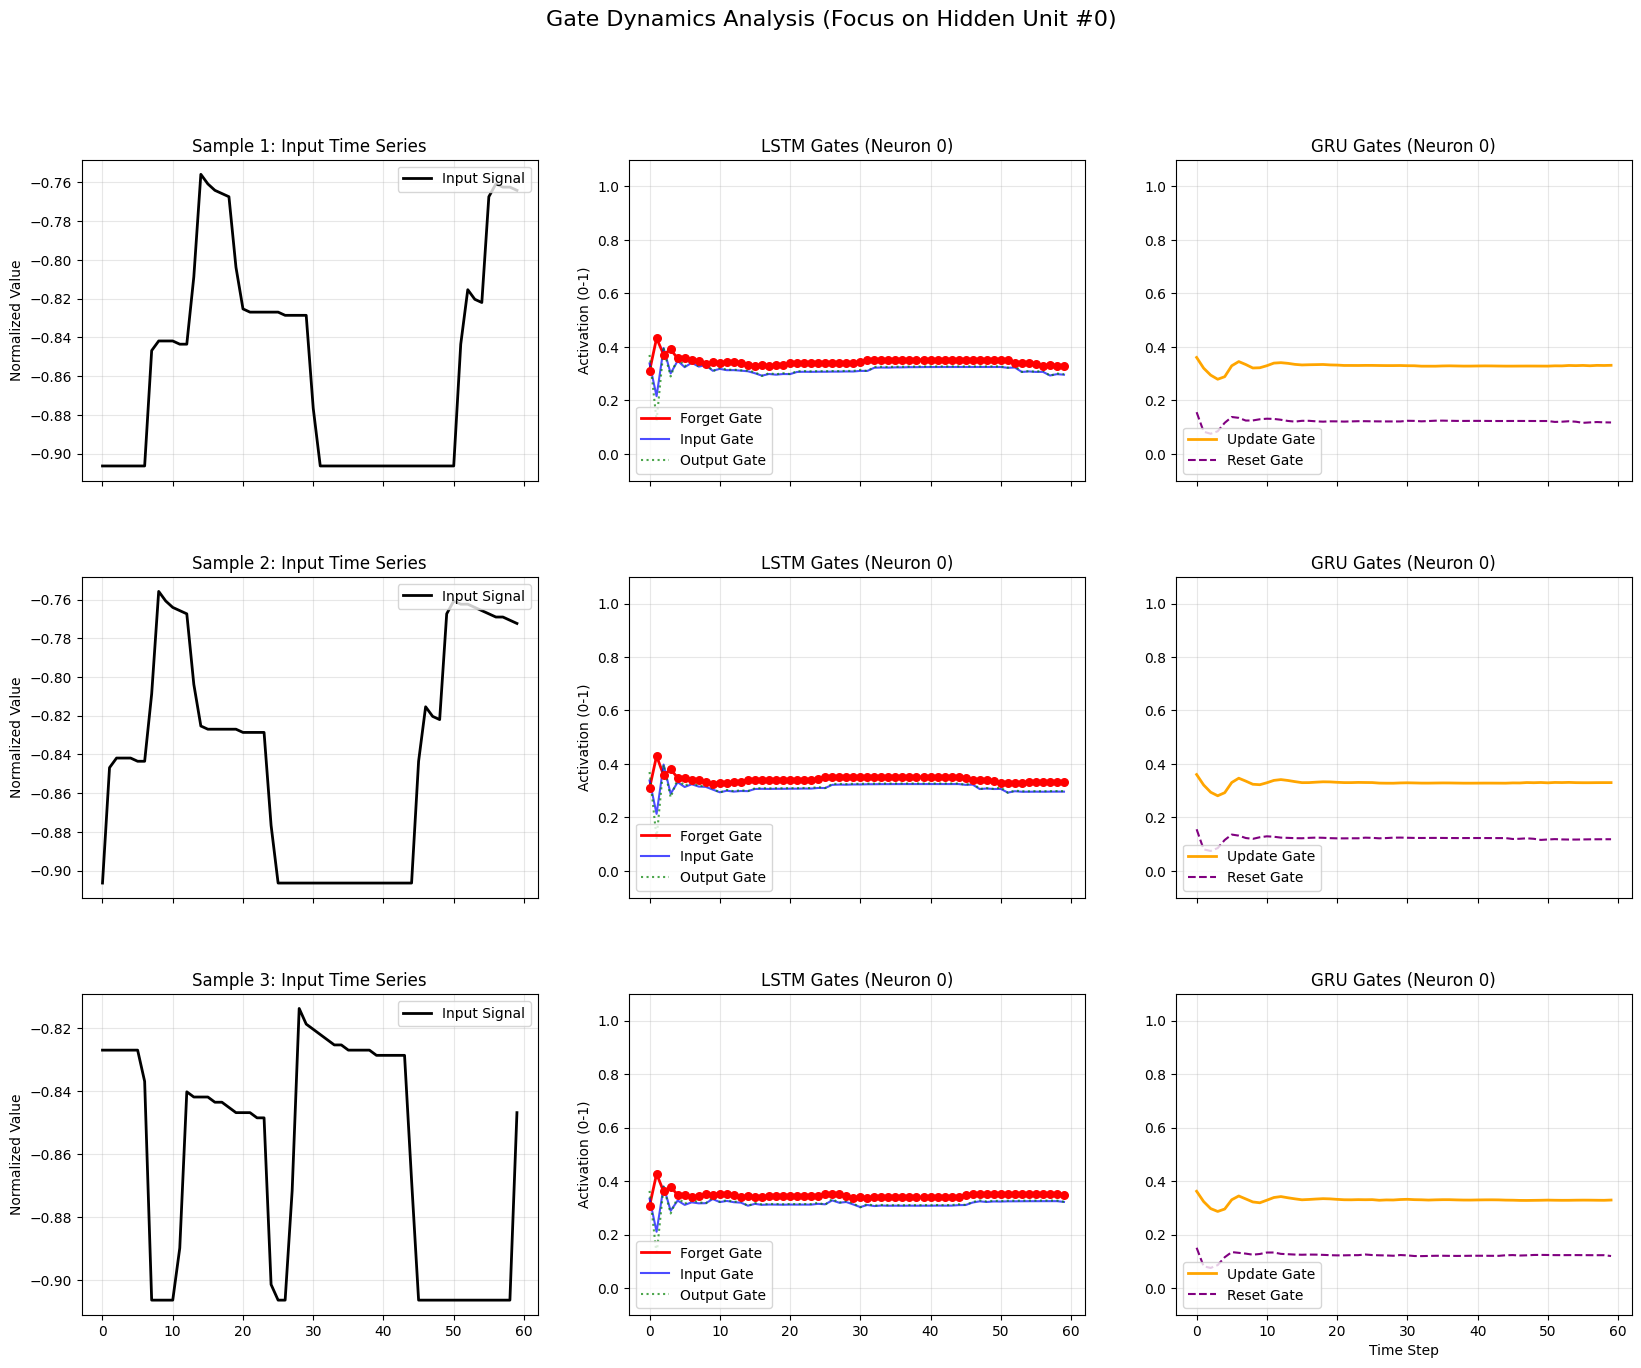

In [14]:
# --- EXECUTION & TEST BLOCK ---

def run_visualization_part_b():
    print("--- Running Part B Visualization ---")
    
    # Check dependencies
    if 'trained_models' not in globals() or not trained_models:
        print("CRITICAL ERROR: Models not found. Please run Part A (Training) first.")
        return

    # 1. Sanity Check on Values
    try:
        dummy_in = torch.randn(1, 60, 1).to(device)
        gates = extract_gate_values(trained_models['LSTMModel'], dummy_in, device, 'LSTM')
        
        # Check Shape: Should be (60, 64)
        expected_shape = (60, 64) 
        if gates['Input'].shape == expected_shape:
            print(f"Shape Check Passed: {gates['Input'].shape}")
        else:
            print(f"Shape Check Failed: Got {gates['Input'].shape}")
            
        # Check Value Range [0, 1]
        if (gates['Forget'].min() >= 0) and (gates['Forget'].max() <= 1):
             print("Value Range Check Passed (0-1).")
        else:
             print("Value Range Check Failed!")
             
    except Exception as e:
        print(f"Error during extraction test: {e}")
        return

    # 2. Generate Plots
    # Try neuron_idx=0 first. If lines are flat, try changing to neuron_idx=5 or 10.
    print("\nGenerating plots for Neuron #0...")
    visualize_gate_dynamics(trained_models, test_loader, device, neuron_idx=0, num_samples=3)

run_visualization_part_b()

# Part C

In [15]:
# ---  DYNAMIC DATA LOADING HELPER ---
def get_loaders_for_length(seq_length, batch_size, device):
    """
    Generates DataLoaders for a specific sequence length using pre-normalized data.
    """
    # Create windows with the requested sequence length
    # Note: reusing global train_data_norm/val/test from Part 1
    X_train, y_train = create_sliding_window(train_data_norm, seq_length)
    X_val, y_val = create_sliding_window(val_data_norm, seq_length)
    X_test, y_test = create_sliding_window(test_data_norm, seq_length)
    
    # Convert to Tensors
    train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_ds = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    
    # Create Loaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_dl, val_dl, test_dl

def test_loader_generation():
    print("--- Testing Dynamic Loader Generation ---")
    try:
        # Test with a dummy length of 30
        t_dl, v_dl, _ = get_loaders_for_length(30, 64, device)
        sample_x, _ = next(iter(t_dl))
        
        if sample_x.shape[1] == 30:
            print(f"Success: Loader produced sequence length 30. Shape: {sample_x.shape}")
        else:
            print(f"Error: Expected length 30, got {sample_x.shape[1]}")
            
    except Exception as e:
        print(f"Failed to generate loaders: {e}")

test_loader_generation()

--- Testing Dynamic Loader Generation ---
Success: Loader produced sequence length 30. Shape: torch.Size([64, 30, 1])


In [16]:
# --- PART C EXPERIMENT ENGINE ---
def run_sequence_dependency_test(seq_lengths, epochs, device):
    """
    Trains all 4 models on varying sequence lengths and returns performance metrics.
    """
    results_list = []
    
    print(f"--- Starting Sequence Dependency Test (Lengths: {seq_lengths}) ---")
    
    for length in seq_lengths:
        print(f"\n[Sequence Length: {length}] Processing...")
        
        # 1. Get DataLoaders for this specific length
        loaders = get_loaders_for_length(length, BATCH_SIZE, device)
        train_dl, val_dl, test_dl = loaders
        
        # 2. Iterate through all model types
        # Re-instantiate models for each length to start fresh
        models_to_train = [SimpleRNNModel, LSTMModel, GRUModel, BiLSTMModel]
        
        for model_class in models_to_train:
            model_name = model_class.__name__
            
            # Init Model
            model = model_class(input_size=1, hidden_size=64, num_layers=2, output_size=1)
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train (Reusing the robust train_model from Part A)
            # We ignore the history return here to save memory, focusing on final test score
            _, trained_model = train_model(model, train_dl, val_dl, criterion, optimizer, epochs, device)
            
            # Evaluate
            test_mse, test_mae = evaluate_model(trained_model, test_dl, criterion, device)
            
            # Record Result
            results_list.append({
                'Sequence Length': length,
                'Model': model_name.replace('Model', ''), # Cleanup name for plot
                'Test MSE': test_mse,
                'Test MAE': test_mae
            })
            
            print(f"  > {model_name} (Len {length}): MSE={test_mse:.4f}")

    return pd.DataFrame(results_list)

In [17]:
# # --- CELL 15: DEBUG EXECUTION (PART C) ---
# # Run this cell for quick verification. Comment out if running Full Training.

# print("!!! RUNNING PART C IN DEBUG MODE !!!")
# # Define lengths as per instructions: 30, 60, 120
# SEQ_LENGTHS_TO_TEST = [30, 60, 120]
# EPOCHS_TO_RUN_C = DEBUG_EPOCHS  # Low epoch count (e.g., 2)

# # Execute
# df_seq_results = run_sequence_dependency_test(SEQ_LENGTHS_TO_TEST, EPOCHS_TO_RUN_C, device)

In [18]:
# --- CELL 16: FULL TRAINING EXECUTION (PART C) ---
# Uncomment this cell for the final analysis. Ensure Debug cell is skipped.

print("!!! RUNNING PART C IN FULL TRAINING MODE !!!")
SEQ_LENGTHS_TO_TEST = [30, 60, 120]
EPOCHS_TO_RUN_C = FULL_EPOCHS  # Target epochs (e.g., 20)

# # Execute
df_seq_results = run_sequence_dependency_test(SEQ_LENGTHS_TO_TEST, EPOCHS_TO_RUN_C, device)

!!! RUNNING PART C IN FULL TRAINING MODE !!!
--- Starting Sequence Dependency Test (Lengths: [30, 60, 120]) ---

[Sequence Length: 30] Processing...
Training SimpleRNNModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4540 [00:00<?, ?it/s]

  > SimpleRNNModel (Len 30): MSE=0.0606
Training LSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4540 [00:00<?, ?it/s]

  > LSTMModel (Len 30): MSE=0.0448
Training GRUModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4540 [00:00<?, ?it/s]

  > GRUModel (Len 30): MSE=0.0478
Training BiLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4540 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4540 [00:00<?, ?it/s]

  > BiLSTMModel (Len 30): MSE=0.0458

[Sequence Length: 60] Processing...
Training SimpleRNNModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

  > SimpleRNNModel (Len 60): MSE=0.0547
Training LSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

  > LSTMModel (Len 60): MSE=0.0457
Training GRUModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

  > GRUModel (Len 60): MSE=0.0469
Training BiLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

  > BiLSTMModel (Len 60): MSE=0.0451

[Sequence Length: 120] Processing...
Training SimpleRNNModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4538 [00:00<?, ?it/s]

  > SimpleRNNModel (Len 120): MSE=0.0712
Training LSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4538 [00:00<?, ?it/s]

  > LSTMModel (Len 120): MSE=0.0457
Training GRUModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4538 [00:00<?, ?it/s]

  > GRUModel (Len 120): MSE=0.0467
Training BiLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4538 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4538 [00:00<?, ?it/s]

  > BiLSTMModel (Len 120): MSE=0.0446


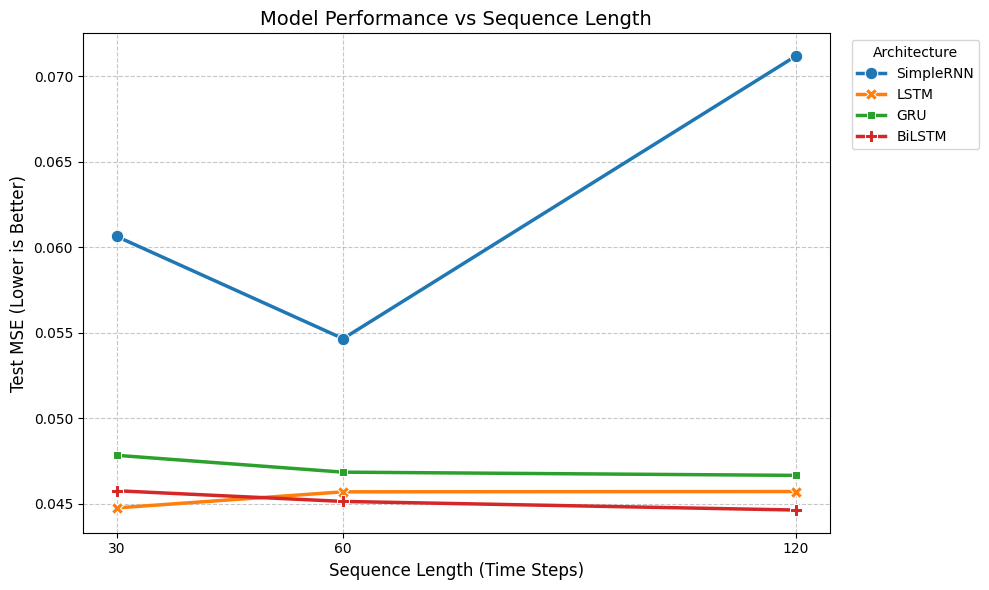


--- Numerical Comparison (Test MSE) ---


Model              BiLSTM       GRU      LSTM  SimpleRNN
Sequence Length                                         
30               0.045770  0.047842  0.044766   0.060644
60               0.045145  0.046858  0.045707   0.054666
120              0.044642  0.046669  0.045724   0.071197

In [19]:
# --- VISUALIZATION (PART C) ---
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings regarding use_inf_as_na (pandas/seaborn compatibility issue)
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_sequence_results(df):
    if df.empty:
        print("Error: No results to plot.")
        return

    plt.figure(figsize=(10, 6))
    
    # Plot MSE vs Sequence Length
    # Markers help visualize the 3 distinct points (30, 60, 120)
    sns.lineplot(data=df, x='Sequence Length', y='Test MSE', hue='Model', style='Model', 
                 markers=True, dashes=False, linewidth=2.5, markersize=9)
    
    plt.title(f'Model Performance vs Sequence Length', fontsize=14)
    plt.ylabel('Test MSE (Lower is Better)', fontsize=12)
    plt.xlabel('Sequence Length (Time Steps)', fontsize=12)
    
    # Ensure x-axis shows exact tested lengths if defined globally
    if 'SEQ_LENGTHS_TO_TEST' in globals():
        plt.xticks(SEQ_LENGTHS_TO_TEST)
        
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Architecture', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Pivot table for numeric analysis
    print("\n--- Numerical Comparison (Test MSE) ---")
    pivot_df = df.pivot(index='Sequence Length', columns='Model', values='Test MSE')
    display(pivot_df)

# Check if results exist in global scope and plot
if 'df_seq_results' in globals() and not df_seq_results.empty:
    plot_sequence_results(df_seq_results)
else:
    print("No results found. Please run previous cells!")

# Part E

In [20]:
import torch
import torch.nn as nn
import pandas as pd
import time

# --- PART E: GATED REMOVAL ABLATION STUDY ---

class CustomLSTMCell(nn.Module):
    """
    A Custom LSTM Cell that allows disabling specific gates for ablation study.
    Equations:
        i = sigmoid(W_i*x + U_i*h + b_i)
        f = sigmoid(W_f*x + U_f*h + b_f)
        o = sigmoid(W_o*x + U_o*h + b_o)
        g = tanh(W_g*x + U_g*h + b_g)
        c_next = f * c_prev + i * g
        h_next = o * tanh(c_next)
    """
    def __init__(self, input_size, hidden_size, gate_mode='full'):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_mode = gate_mode
        
        # Linear layers for weights (x -> gates and h -> gates)
        # We concatenate 4 gates: Input, Forget, Cell(g), Output
        self.weight_ih = nn.Linear(input_size, 4 * hidden_size)
        self.weight_hh = nn.Linear(hidden_size, 4 * hidden_size)
        
        self.init_weights()

    def init_weights(self):
        # Xavier initialization for input weights
        nn.init.xavier_uniform_(self.weight_ih.weight)
        # Orthogonal initialization for recurrent weights
        nn.init.orthogonal_(self.weight_hh.weight)
        
        # Initialize bias
        # Note: Standard LSTM often initializes forget gate bias to 1.0, 
        # but here we keep it 0.0 to match PyTorch default for fair comparison.
        if self.weight_ih.bias is not None:
            nn.init.zeros_(self.weight_ih.bias)
        if self.weight_hh.bias is not None:
            nn.init.zeros_(self.weight_hh.bias)

    def forward(self, x, state):
        h_prev, c_prev = state
        
        # Compute all gates at once
        gates = self.weight_ih(x) + self.weight_hh(h_prev)
        
        # Split into 4 tensors: i, f, g, o
        i_gate, f_gate, g_gate, o_gate = gates.chunk(4, 1)
        
        # Apply activations
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        g_gate = torch.tanh(g_gate)
        o_gate = torch.sigmoid(o_gate)
        
        # Apply Ablation Logic based on gate_mode
        if self.gate_mode == 'forget_only':
            # "LSTM with only forget gate active (input and output always 1)"
            # f_gate is computed normally
            i_gate = torch.ones_like(i_gate)
            o_gate = torch.ones_like(o_gate)
            
        elif self.gate_mode == 'input_only':
            # "LSTM with only input gate active (forget and output always 1)"
            # i_gate is computed normally
            f_gate = torch.ones_like(f_gate)
            o_gate = torch.ones_like(o_gate)
            
        elif self.gate_mode == 'full':
            # Standard LSTM behavior (all gates active)
            pass
            
        # Update cell state
        c_next = f_gate * c_prev + i_gate * g_gate
        
        # Update hidden state
        h_next = o_gate * torch.tanh(c_next)
        
        return h_next, c_next

class CustomLSTMLayer(nn.Module):
    """
    Wraps the CustomLSTMCell to process a sequence of inputs.
    Mimics nn.LSTM with batch_first=True.
    """
    def __init__(self, input_size, hidden_size, num_layers=2, gate_mode='full'):
        super(CustomLSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # Input dim for first layer is input_size, for others it's hidden_size
            layer_input_dim = input_size if i == 0 else hidden_size
            self.layers.append(CustomLSTMCell(layer_input_dim, hidden_size, gate_mode))
            
    def forward(self, x):
        # x shape: (Batch, Seq, Feature)
        batch_size, seq_len, _ = x.size()
        device = x.device
        
        # Initialize hidden and cell states
        h_t = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_size).to(device) for _ in range(self.num_layers)]
        
        outputs = []
        
        # Loop over time steps
        for t in range(seq_len):
            x_step = x[:, t, :]
            
            # Pass through stacked layers
            for layer_idx, layer in enumerate(self.layers):
                h_prev, c_prev = h_t[layer_idx], c_t[layer_idx]
                h_next, c_next = layer(x_step, (h_prev, c_prev))
                
                # Update states
                h_t[layer_idx] = h_next
                c_t[layer_idx] = c_next
                
                # Output of this layer is input to the next layer
                x_step = h_next
            
            # Store the output of the last layer
            outputs.append(x_step.unsqueeze(1))
            
        # Concatenate outputs along sequence dimension
        outputs = torch.cat(outputs, dim=1)
        return outputs

class AblationLSTMModel(nn.Module):
    """
    Model wrapper using the CustomLSTMLayer for Part E.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, gate_mode='full'):
        super(AblationLSTMModel, self).__init__()
        self.rnn = CustomLSTMLayer(input_size, hidden_size, num_layers, gate_mode)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (Batch, Seq, Feature)
        out = self.rnn(x)
        
        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Final prediction
        out = self.fc(out)
        return out

def run_ablation_experiment(epochs, device):
    """
    Trains and evaluates the 3 versions of LSTM (Forget Only, Input Only, Full).
    """
    # Configuration for Part E
    SEQ_LENGTH_E = 60 # Standard length
    HIDDEN_SIZE = 64
    NUM_LAYERS = 2
    OUTPUT_SIZE = 1
    
    # Get DataLoaders (Reuse the helper from Part C or assume it exists)
    # Using batch_size=64 as per instructions
    train_loader, val_loader, test_loader = get_loaders_for_length(SEQ_LENGTH_E, 64, device)
    
    # Determine input size dynamically
    input_dim = next(iter(train_loader))[0].shape[2]
    
    # Define modes to test
    modes = [
        ('Full LSTM', 'full'),
        ('Forget Gate Only', 'forget_only'),
        ('Input Gate Only', 'input_only')
    ]
    
    results = []
    
    print(f"--- Starting Ablation Study (Epochs: {epochs}) ---")
    
    for name, mode in modes:
        print(f"\nTraining Model: {name} (Mode: {mode})")
        
        # Initialize model
        model = AblationLSTMModel(input_dim, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, gate_mode=mode)
        model.to(device)
        
        # Define Loss and Optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Train (Assuming train_model is defined in previous cells)
        train_hist, trained_model = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs, device
        )
        
        # Evaluate (Assuming evaluate_model is defined in previous cells)
        mse, mae = evaluate_model(trained_model, test_loader, criterion, device)
        
        print(f"Results for {name}: MSE={mse:.4f}, MAE={mae:.4f}")
        
        results.append({
            'Model Version': name,
            'Gate Mode': mode,
            'Test MSE': mse,
            'Test MAE': mae
        })
        
    return pd.DataFrame(results)

In [21]:
# # --- CELL: DEBUG EXECUTION (PART E) ---
# # Run this cell to verify Part E implementation quickly.

# print("!!! RUNNING PART E IN DEBUG MODE !!!")
# EPOCHS_TO_RUN_E = DEBUG_EPOCHS # Reuse global debug setting (e.g. 2)

# df_ablation_results = run_ablation_experiment(EPOCHS_TO_RUN_E, device)

# print("\n--- Ablation Study Debug Results ---")
# print(df_ablation_results)

In [22]:
# --- CELL: FULL TRAINING EXECUTION (PART E) ---
# Uncomment below for the final report generation.

print("!!! RUNNING PART E IN FULL TRAINING MODE !!!")
EPOCHS_TO_RUN_E = FULL_EPOCHS  # Reuse global full setting (e.g. 20)

df_ablation_results = run_ablation_experiment(EPOCHS_TO_RUN_E, device)

print("\n--- Ablation Study Final Results ---")
print(df_ablation_results)

!!! RUNNING PART E IN FULL TRAINING MODE !!!
--- Starting Ablation Study (Epochs: 20) ---

Training Model: Full LSTM (Mode: full)
Training AblationLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Results for Full LSTM: MSE=0.0461, MAE=0.0793

Training Model: Forget Gate Only (Mode: forget_only)
Training AblationLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Results for Forget Gate Only: MSE=0.0578, MAE=0.1238

Training Model: Input Gate Only (Mode: input_only)
Training AblationLSTMModel for 20 epochs...


Epoch 1/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4539 [00:00<?, ?it/s]

Results for Input Gate Only: MSE=0.0520, MAE=0.0871

--- Ablation Study Final Results ---
      Model Version    Gate Mode  Test MSE  Test MAE
0         Full LSTM         full  0.046112  0.079261
1  Forget Gate Only  forget_only  0.057776  0.123804
2   Input Gate Only   input_only  0.051964  0.087089
